# Notebook for running growth rates on cases by gender in Denmark

We replicate our growth rate analysis on cases separated by gender in Denmark, which is publicly available. This gives an indication of how the code would run if data were to be entered for different strains (which is not publicly available)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as pl

import pickle as pk
from datetime import datetime, timedelta

import seaborn as sns

## Read in data available from the SSI Covid-19 Dashboard

Here we read in the data and separate into two 'lineages'. These are not really lineages of course, but rather the outbreaks amongs male and female cases, so it's somewhat of a toy example, but is just given to illustrate how the code works. Data is available publicly via: https://experience.arcgis.com/experience/220fef27d07d438889d651cc2e00076c/page/Covid-19-Regionalt/ 

In [2]:
ssi_data = pd.read_csv('data/03_bekraeftede_tilfaelde_doede_indlagte_pr_dag_pr_koen.csv', sep = ';', encoding='unicode_escape')
ssi_data = ssi_data.loc[ssi_data['Prøvetagningsdato'].between('2021-01-01', '2021-12-31')]
cases_by_day = ssi_data.groupby('Prøvetagningsdato').sum('Bekræftede tilfælde i alt')['Bekræftede tilfælde i alt'].values
cases_f = ssi_data.loc[ssi_data['Køn'] == 'F'].groupby('Prøvetagningsdato').sum('Bekræftede tilfælde i alt')['Bekræftede tilfælde i alt'].values
cases_m = ssi_data.loc[ssi_data['Køn'] == 'M'].groupby('Prøvetagningsdato').sum('Bekræftede tilfælde i alt')['Bekræftede tilfælde i alt'].values

In [3]:
day_counts = pd.DataFrame(np.vstack((cases_by_day, cases_f, cases_m)).T, columns = ['All', 'Female', 'Male'])
day_counts.index.name = 'DaysSinceStart'
ndays = len(day_counts)
day_counts

,All,Female,Male
DaysSinceStart,,,
0,1203,628,575
1,2046,1047,999
2,1670,915,755
3,2479,1329,1150
4,1929,1078,851
...,...,...,...
360,23861,12238,11623
361,23171,11921,11250
362,18236,9306,8930


In [7]:
t_ranges = {'Male' : np.array((0, 364)), 'Female' : np.array((0, 364))}

import time
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_value,
)


# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )


# helper function for doing hmc inference
def run_inference(model, rng_key, X, Y, num_warmup=1000, num_samples=200, num_chains = 2, thinning = 1):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies

    init_strategy = init_to_value(
        values={"kernel_var": 1.0, "kernel_noise": 1., "kernel_length": 1.}
        )
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup= num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        thinning=thinning,
        progress_bar=True,
    )

    mcmc.run(rng_key, X.flatten(), Y.flatten())
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    # Keep noise for full kernel
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    return mean, mean + sigma_noise

In [ ]:
df_counts = day_counts.copy()

# Growth rates output
r_store = pd.DataFrame()
r_boot = {}

for i, lineage in enumerate(df_counts.columns[1:]):

      start_time = time.time()


      print(f'Loaded data for {lineage}')

      columns = ['All', lineage]
      df = df_counts[columns].dropna()
      # Days
      X0 = df.index.to_numpy()
      X0_min, X0_max = X0[[0, -1]]
      X1 = np.arange(X0_min, X0_max+1)

      # If statement to do Gaussian Process classification

      print('Running GP regression')
      y_all = df.eval(f'All - `{lineage}`')
      y_lineage = df[lineage]

      X0 = X0
      # log(data+1)
      y1 = np.atleast_2d(np.log(y_all+1)).T
      y2 = np.atleast_2d(np.log(y_lineage+1)).T


      rng_key, rng_key_predict = random.split(random.PRNGKey(0))
      samples1 = run_inference(model, rng_key, X0.flatten(), y1.flatten())
      print('First Fitting Done in ' + str(time.time() - start_time) + ' seconds')
      # Prediction

      vmap_args1 = (
      random.split(rng_key_predict, samples1["kernel_var"].shape[0]),
      samples1["kernel_var"],
      samples1["kernel_length"],
      samples1["kernel_noise"],
        )


      means1, predictions1 = vmap(
      lambda rng_key, var, length, noise: predict(
          rng_key, X1, y1.flatten(), X0, var, length, noise
              )
      )(*vmap_args1)

      mean_prediction1 = np.mean(means1, axis=0)
      percentiles1 = np.percentile(predictions1, [5.0, 95.0], axis=0)

      print('First Prediction Done in ' + str(time.time() - start_time) + ' seconds')

      samples2 = run_inference(model, rng_key, X0.flatten(), y2.flatten())

      print('Second Fitting Done in ' + str(time.time() - start_time) + ' seconds')

      vmap_args2 = (
      random.split(rng_key_predict, samples2["kernel_var"].shape[0]),
      samples2["kernel_var"],
      samples2["kernel_length"],
      samples2["kernel_noise"],
        )

      means2, predictions2 = vmap(
      lambda rng_key, var, length, noise: predict(
          rng_key, X1, y2.flatten(), X0, var, length, noise
              )
      )(*vmap_args2)

      print('Second Prediction Done in ' + str(time.time() - start_time) + ' seconds')

      mean_prediction2 = np.mean(means2, axis=0)
      percentiles2 = np.percentile(predictions2, [5.0, 95.0], axis=0)


      diffs2 = np.diff(predictions2, axis = 1)
      diffs1 = np.diff(predictions1, axis = 1)
      # Changed this so that it's the right way around
      drs = diffs2 - diffs1
      dr_means = np.mean(drs, axis = 0)
      dr_percentiles = np.percentile(drs, [5.0, 95.0], axis=0)

      r_boot[lineage] = drs

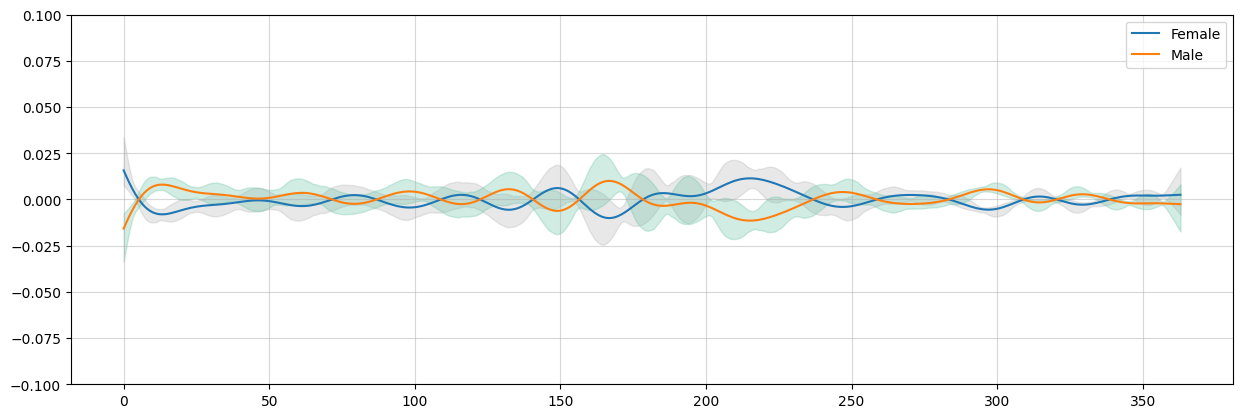

In [37]:
cmp = sns.color_palette('Set2')
fig, ax = plt.subplots()
fig.set_figwidth(15)
ax.grid(alpha = 0.5)
# percentiles21 = np.percentile(predictions21, [5.0, 95.0], axis=0)

for idx, lab in enumerate(df_counts.columns[1:]):
    t_min, t_max = [0, 364]

    drs = r_boot[lab]
    dr_means = np.mean(drs, axis = 0)
    dr_percentiles = np.percentile(drs, [5.0, 95.0], axis=0)
    ax.plot(np.arange(t_min, t_max), dr_means[t_min:t_max] , label = lab)
    # plot 90% confidence level of predictions
    ax.fill_between(X0[t_min:t_max], dr_percentiles[0, t_min:t_max], dr_percentiles[1, t_min:t_max] , color=cmp[idx-1], alpha = 0.3)
# plot mean prediction
ax.set_ylim([-0.1, 0.1])
ax.set_xlabel('Days')
ax.set_ylabel('Growth Rate')
ax.legend()